In [7]:
from math import *
import matplotlib.pyplot as plt
from scipy.integrate import ode
import time
import matplotlib.pyplot as plt
import gym
import torch as th
import os
from datetime import datetime
import csv
import numpy as np

from stable_baselines3 import TD3, SAC
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from bipedalWalkerPMTG import BipedalWalkerPMTG

In [8]:
log_dir = "./models/PMTG_SAC-bipedalWalker2d_velctrl-model"
is_hard = False

Load the model and create environment

In [9]:
bm_save_path = os.path.join(log_dir, 'best_model')
model = SAC.load(bm_save_path)

env = BipedalWalkerPMTG(
    is_hard=is_hard, 
    action_repeat=3, 
    act_noise=0, 
    rew_scale=5, 
    learn=False,
    vel_ctrl=True)

env = Monitor(env, log_dir)

In [10]:
vel_x = []
ref_vel_x = []
t = []
it = 0

obs = env.reset()
while it < 35:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    if it < 4:
        env.set_ref_vel(0.7)
    else:
        env.set_ref_vel(0.3)

    env.render()
    it += 1/50
    vel_x.append(obs[2])
    ref_vel_x.append(obs[14])
    t.append(it)
    if done == True:
        env.reset()
        break

vel_x[:] = [x*2 for x in vel_x]

In [11]:
env.close()

Show the velocity plot

black - desired velocity

blue - real velocity

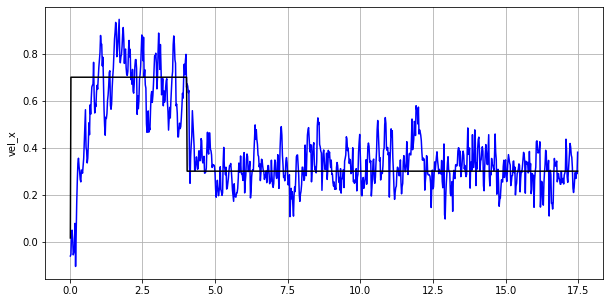

In [12]:
fig = plt.figure(figsize=(10,5),
            facecolor='white')

plt.grid()
plt.plot(t, vel_x, 'b')
plt.plot(t, ref_vel_x, 'k')
plt.ylabel("vel_x")

plt.show()

Here you can control the robot via Sony Dualshock 4 controller.

If you don't have Sony Dualshock 4 controller you don't need to run this part

In [6]:
from pyPS4Controller.controller import Controller

ref_vel_loc = 0

class MyController(Controller):

    def __init__(self, **kwargs):
        Controller.__init__(self, **kwargs)

    def on_x_press(self):
       print("Hello world")

    def on_x_release(self):
       print("Goodbye world")
       
    def on_right_arrow_press(self):
        global ref_vel_loc
        if ref_vel_loc <= 0.5:
            ref_vel_loc += 0.1
        print("Ref velocity: {0}\r\n".format(ref_vel_loc))

    def on_left_arrow_press(self):
        global ref_vel_loc
        if ref_vel_loc >= 0.1:
            ref_vel_loc -= 0.1
        print("Ref velocity: {0}\r\n".format(ref_vel_loc))

    def on_R2_press(self, value):
        global ref_vel_loc
        ref_vel_loc = 0.3*(value/32767)+0.3
        print("Ref velocity: {0}\r\n".format(ref_vel_loc))

    def on_R2_release(self):
        global ref_vel_loc
        ref_vel_loc = 0
        print("Ref velocity: {0}\r\n".format(ref_vel_loc))

In [7]:
vel_x = []
ref_vel_x = []
t = []
it = 0

def robot_run():
    global it
    global vel_x
    global ref_vel_x
    
    obs = env.reset()
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)
        env.set_ref_vel(ref_vel_loc)
        env.render()
        it += 1/50
        vel_x.append(obs[2])
        ref_vel_x.append(obs[14])
        t.append(it)

Press R2 in order to control the robot velocity

In [8]:
from threading import Thread

# input here your dualshock address
controller_name = "/dev/input/js4"

th_robot = Thread(target=robot_run, args=())
th_robot.start()

controller = MyController(interface=controller_name, connecting_using_ds4drv=False)
controller.listen(timeout=60)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_91724/1655441042.py", line 13, in robot_run
  File "/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/base_class.py", line 562, in predict
    return self.policy.predict(observation, state, episode_start, deterministic)
  File "/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/policies.py", line 335, in predict
    observation, vectorized_env = self.obs_to_tensor(observation)
  File "/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/policies.py", line 250, in obs_to_tensor
    vectorized_env = is_vectorized_observation(observation, self.observation_space)
  File "/home/yoggi/biped_research/env/lib/python3.8/sit

Waiting for interface: /dev/input/js4 to become available . . .
Successfully bound to: /dev/input/js4.
